# GNN Turbulence Model
## Load in dataset
### Dataset is in cartesian, convert to staggered points in 

In [1]:
import sys
import numpy as np
import torch
from tqdm.notebook import tqdm


from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.spatial import Voronoi, Delaunay

from models.models import *
from src.mesh_util import *
from src.data_util import *

In [2]:
# load data

# filenames = {'baseline_64': 'kolmogorov_re_1000/eval_2048x2048_64x64.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000/long_eval_2048x2048_64x64.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000/eval_64x64_64x64.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000_fig1/baseline_64x64.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_1000_fig1/baseline_256x256.nc'}
filenames = {'baseline_64': 'kolmogorov_re_1000_fig1/baseline_2048x2048.nc'}
# filenames = {'baseline_64': 'kolmogorov_re_4000/eval_128x128_128x128.nc'}
# filenames = {'baseline_64': 'decaying/eval_1024x1024_64x64.nc'}

data = load_dataset(filenames,path='data/')
data = data['baseline_64']
dt = data.stable_time_step

x_range = (data.x.min().item(),data.x.max().item())
y_range = (data.y.min().item(),data.y.max().item())

x_range = (0,2*np.pi)
y_range = (0,2*np.pi)

print(x_range,y_range)


(0, 6.283185307179586) (0, 6.283185307179586)


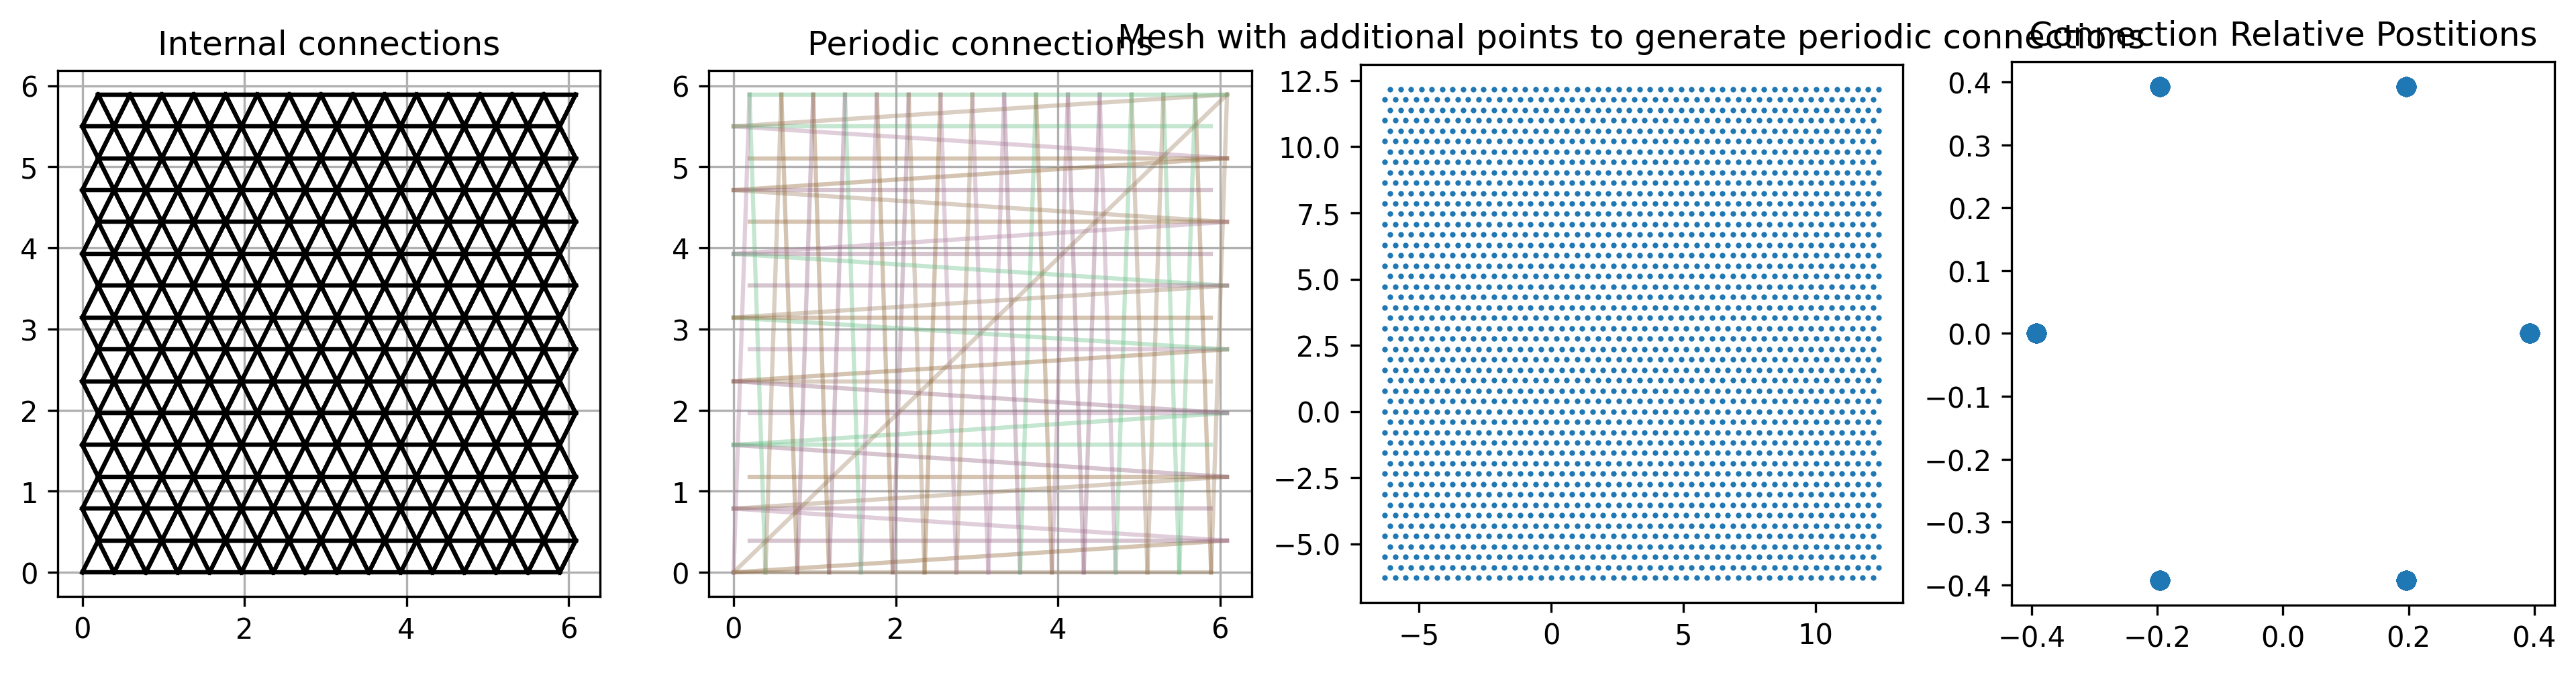

In [3]:

# setup mesh

rows = 64
cols = 64

rows = 16
cols = 16

staggered_points = np.empty((rows,cols,2))

# consistent spacing
dx = (x_range[1]-x_range[0])/(rows)
dy = (y_range[1]-y_range[0])/(cols)
staggered_points[:,:,1] = np.arange(y_range[0],y_range[1]-dy/10,dy)[:,np.newaxis]
for i in range(rows):
    point_row = np.arange(x_range[0],x_range[1]-6*dx/10,dx)
    staggered_points[i,:,0] = point_row + i%2*(dx/2) # stagger
    # staggered_points[i,:,0] = point_row 

staggered_points = staggered_points.reshape(-1,2)

# staggered_points = np.random.uniform(0,2*np.pi,staggered_points.shape)

mesh_nonperiodic = Delaunay(staggered_points)

connectivity_nonperiodic = delanay_simplex_to_connectivity_array(mesh_nonperiodic,True)

spacing = (x_range[1]-x_range[0])/(rows-1)
original_spacing = (data.x.max().values - data.x.min().values)/64
# mesh, connectivity, connectivity_periodic, edge_attr = delanay_mesh_constructor(staggered_points,periodic=True,bidirectional=True,periodic_limits=np.array([[x_range[0],x_range[1]+dx/2],[y_range[0],y_range[1]+dy]]))
mesh, connectivity, connectivity_periodic, edge_attr, edge_attr_periodic = delanay_mesh_constructor(staggered_points,periodic=True,bidirectional=True,periodic_limits=np.array([[x_range[0],x_range[1]],[y_range[0],y_range[1]]]))
# mesh, connectivity, connectivity_periodic, dx = delanay_mesh_constructor(staggered_points,periodic=True,bidirectional=True,periodic_limits=np.array([[0,2*np.pi],[0,2*np.pi]]))

fig = plt.figure(figsize=(16,6),dpi=300)
ax = fig.add_subplot(141)
ax.plot(staggered_points[connectivity,0],staggered_points[connectivity,1],c='k')
ax.set_aspect('equal')
ax.set_title('Internal connections')
ax.grid(True)
ax = fig.add_subplot(142)
ax.plot(staggered_points[connectivity_periodic,0],staggered_points[connectivity_periodic,1],alpha=0.2)
ax.set_title('Periodic connections')
ax.set_aspect('equal')
ax.grid(True)

# fig = plt.figure(figsize=(6,6),dpi=300)
ax = fig.add_subplot(143)
ax.scatter(mesh.points[:,0],mesh.points[:,1],s=1)
ax.set_title('Mesh with additional points to generate periodic connections')
ax.set_aspect('equal')
# plt.show()


# combine connectivities
connectivity_combined = np.concatenate([connectivity,connectivity_periodic],axis=1)

# combine relative position
edge_attr_combined = np.concat([edge_attr,edge_attr_periodic],axis=0)

# fig = plt.figure(figsize=(16,5),dpi=300)
ax = fig.add_subplot(144)
ax.scatter(edge_attr_combined[:,0],edge_attr_combined[:,1])
ax.set_aspect('equal')
ax.set_title('Connection Relative Postitions')
plt.show()

## Interpolation of values
### Original data is in cartesian system. Convert to polygon points from previously generated mesh

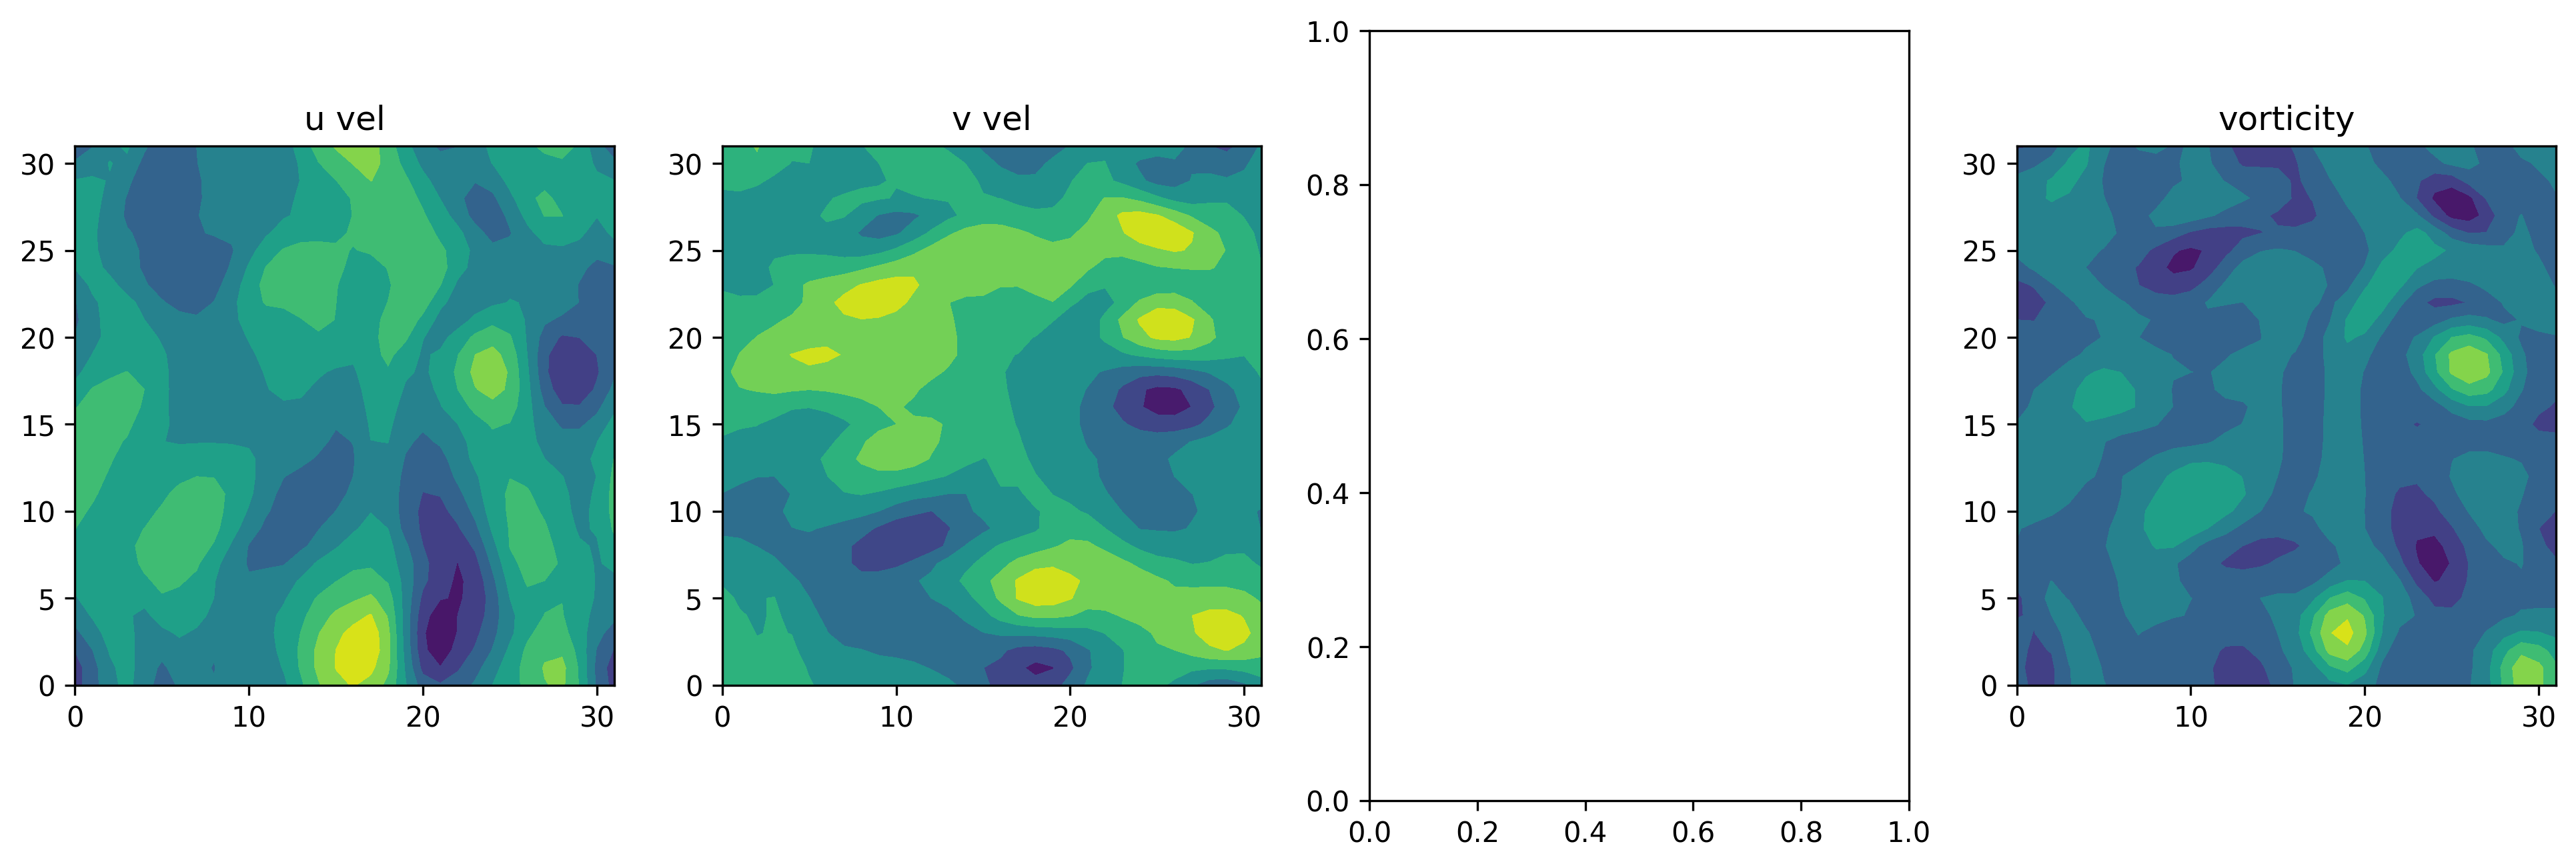

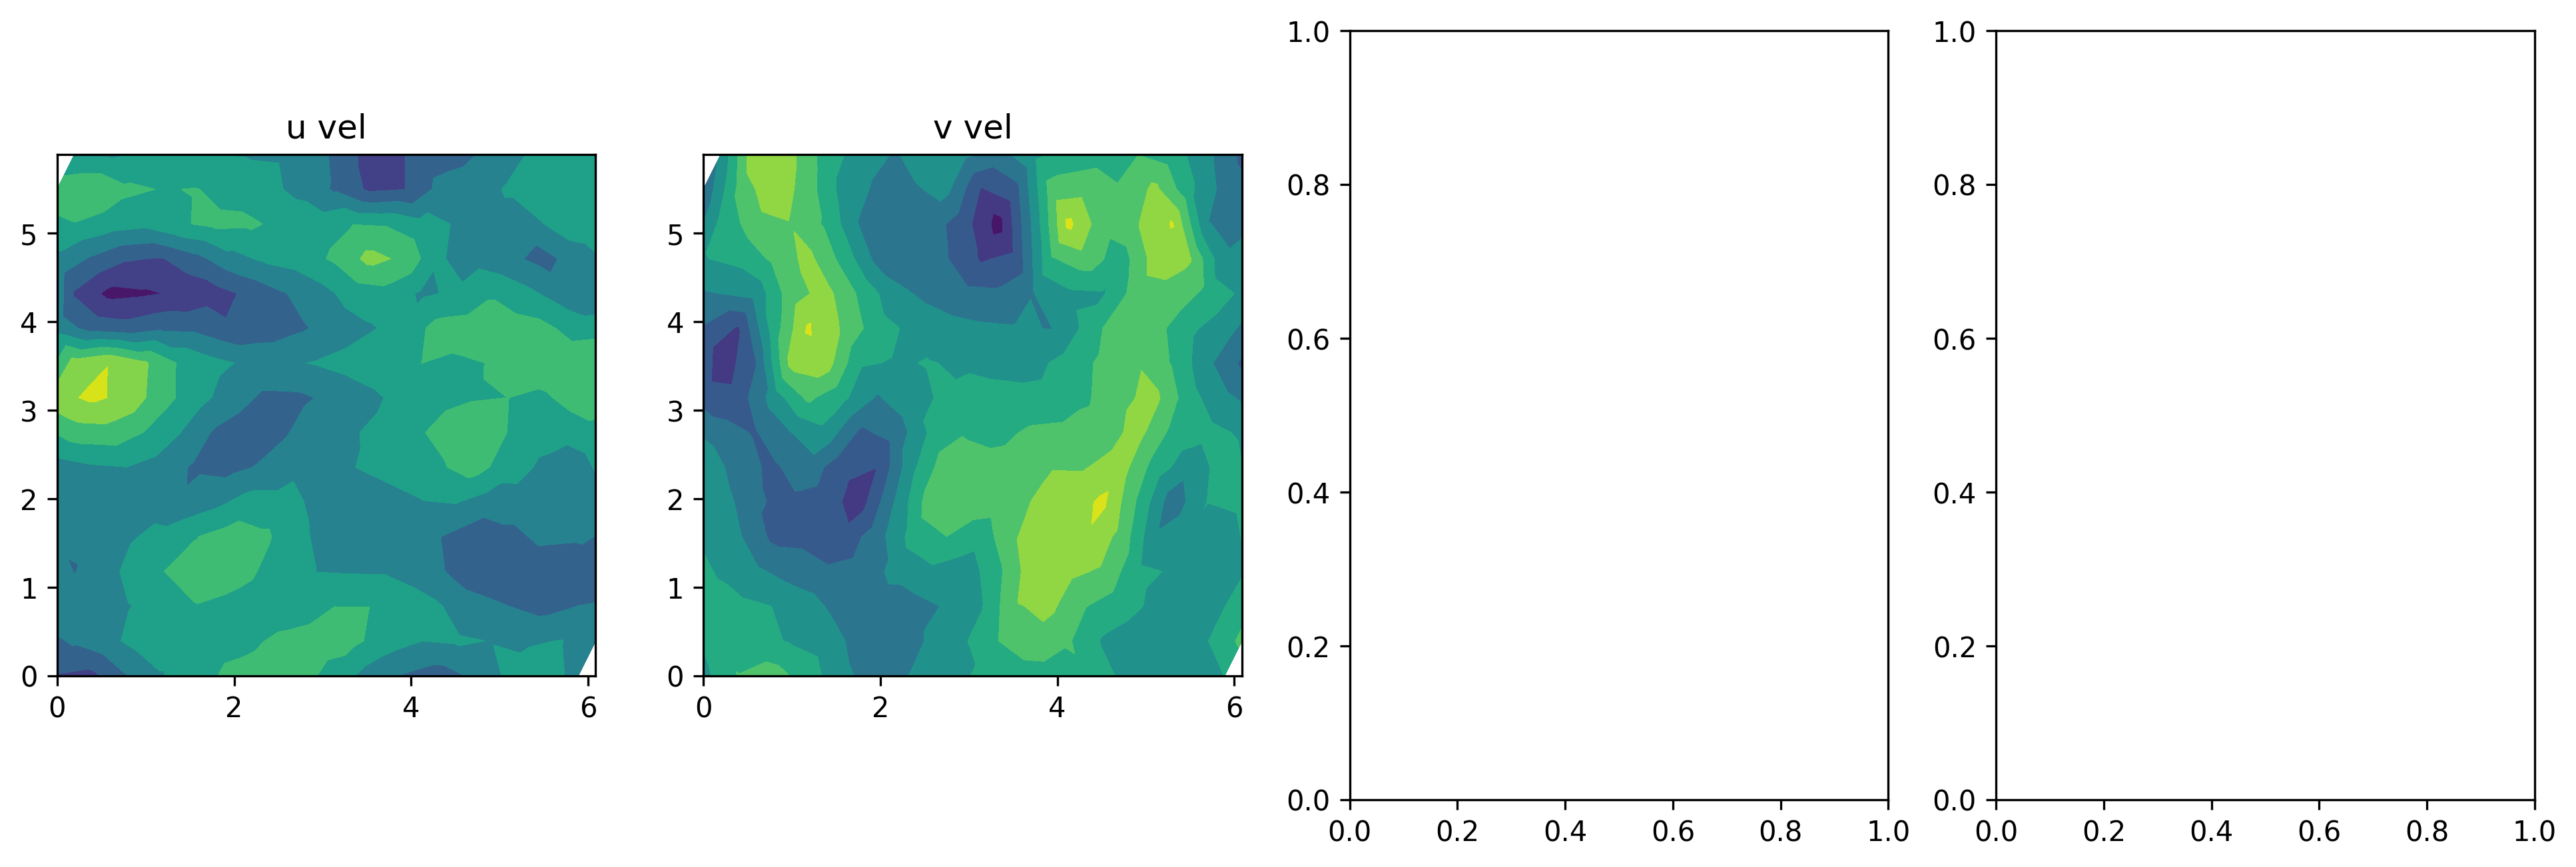

In [4]:
from scipy.interpolate import RegularGridInterpolator

rho = 1.0


# plot figures
timestep = 0
sample_ind = 0
fig = plt.figure(figsize=(16,5),dpi=300)
ax = fig.add_subplot(141)
ax.contourf(data.u[sample_ind,timestep])
ax.set_aspect('equal')
ax.set_title('u vel')
ax = fig.add_subplot(142)
ax.contourf(data.v[sample_ind,timestep])
ax.set_aspect('equal')
ax.set_title('v vel')
ax = fig.add_subplot(143)
# ax.contourf(data.pressure[sample_ind,timestep])
# ax.set_aspect('equal')
# ax.set_title('pressure')
ax = fig.add_subplot(144)
ax.contourf(data.vorticity[sample_ind,timestep])
ax.set_aspect('equal')
ax.set_title('vorticity')


plt.show()

sample_inds = data.sample
time_arr = data.time


# periodicity of domain
x = np.empty(len(data.x)+2)
y = np.empty(len(data.y)+2)
x[1:-1] = data.x
y[1:-1] = data.y

x[0] = data.x[0] - (data.x[1]-data.x[0])
x[-1] = data.x[-1] + (data.x[-1]-data.x[-2])
y[0] = data.y[0] - (data.y[1]-data.y[0])
y[-1] = data.y[-1] + (data.y[-1]-data.y[-2])

u = np.empty((*data.u.shape[:2],data.u.shape[2]+2,data.u.shape[3]+2))
v = np.empty((*data.u.shape[:2],data.v.shape[2]+2,data.v.shape[3]+2))
u[:,:,1:-1,1:-1] = data.u
v[:,:,1:-1,1:-1] = data.v
u[:,:,0] = u[:,:,-2]
v[:,:,0] = v[:,:,-2]
u[:,:,-1] = u[:,:,1]
v[:,:,-1] = v[:,:,1]
u[:,:,:,0] = u[:,:,:,-2]
v[:,:,:,0] = v[:,:,:,-2]
u[:,:,:,-1] = u[:,:,:,1]
v[:,:,:,-1] = v[:,:,:,1]

interp_u = RegularGridInterpolator([data.sample,data.time,x,y],u,bounds_error=False)
interp_v = RegularGridInterpolator([data.sample,data.time,x,y],v,bounds_error=False)

# reshape with samples and time steps
# extend last dimension by 2 to include sample and time info
staggered_points_full_set = np.tile(staggered_points,[len(data.sample),len(data.time),1,2])
staggered_points_full_set[:,:,:,0] = data.sample.to_numpy()[:,np.newaxis,np.newaxis]
staggered_points_full_set[:,:,:,1] = data.time.to_numpy()[np.newaxis,:,np.newaxis]
flattened = staggered_points_full_set.reshape(-1,4) # [[sample, time, x, y], ...]

staggered_points_u = interp_u(flattened) # [u, ...]
staggered_points_v = interp_v(flattened)

staggered_points_full_set_vel = np.stack([staggered_points_u.reshape(len(data.sample),len(data.time),rows,cols),staggered_points_v.reshape(len(data.sample),len(data.time),rows,cols)],axis=4)

fig = plt.figure(figsize=(16,5),dpi=300)
ax = fig.add_subplot(141)
ax.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),staggered_points_full_set[0,0,:,3].flatten(),staggered_points_full_set_vel[0,0,:,:,0].flatten())
ax.set_aspect('equal')
ax.set_title('u vel')
ax = fig.add_subplot(142)
ax.tricontourf(staggered_points_full_set[0,0,:,2].flatten(),staggered_points_full_set[0,0,:,3].flatten(),staggered_points_full_set_vel[0,0,:,:,1].flatten())
ax.set_aspect('equal')
ax.set_title('v vel')
ax = fig.add_subplot(143)
ax = fig.add_subplot(144)
plt.show()


In [5]:
ind_skip = 4
dt_skip = ind_skip*dt
skip = staggered_points_full_set_vel[:,::ind_skip]
train_test_split = 0.8

train_data = skip[:int(skip.shape[0]*train_test_split)]
test_data = skip[int(skip.shape[0]*train_test_split):]

# torch.randperm()


# set device
e = torch.tensor(edge_attr_combined,dtype=torch.float32).to('mps')
train_input = torch.tensor(train_data[:,:-1],dtype=torch.float32).to('mps')
train_target = torch.tensor(train_data[:,1:],dtype=torch.float32).to('mps')
# train_target = (train_target - train_input)/dt_skip
print(train_input.mean())
print(train_input.std())
print(train_target.mean())
print(train_target.std())

test_input = torch.tensor(test_data[:,:-1],dtype=torch.float32).to('mps')
test_target = torch.tensor(test_data[:,1:],dtype=torch.float32).to('mps')
# test_target = (test_target - test_input)/dt_skip
tmp = test_target.detach().clone()
tmp = tmp.reshape(tmp.shape[0],tmp.shape[1],rows*cols,2)

ij = torch.tensor(connectivity_combined,dtype=torch.long).to('mps')

train_input = train_input.reshape(-1,rows*cols,2)
test_input = test_input.reshape(-1,rows*cols,2)
train_target = train_target.reshape(-1,rows*cols,2)
test_target = test_target.reshape(-1,rows*cols,2)

print(train_input.shape)
print(test_input.shape)
print(train_target.shape)
print(test_target.shape)
print(ij.shape)
print(e.shape)



tensor(-1.5428e-07, device='mps:0')
tensor(0.9462, device='mps:0')
tensor(-1.5433e-07, device='mps:0')
tensor(0.9463, device='mps:0')
torch.Size([7320, 256, 2])
torch.Size([2440, 256, 2])
torch.Size([7320, 256, 2])
torch.Size([2440, 256, 2])
torch.Size([2, 1536])
torch.Size([1536, 2])


In [6]:


# train model

# construct model
model = MeshGraphNet(npasses=2,
                     ndim=16,
                     node_fc_depth=2,
                     edge_fc_depth=2,
                     node_input_dim=2,
                     edge_input_dim=2,
                     activation=nn.SiLU(),
                     dropout_rate=0.10).to('mps')

opt = torch.optim.Adam(model.parameters(),lr=1e-3)
decay = torch.optim.lr_scheduler.ExponentialLR(opt,0.9999)
# decay = torch.optim.lr_scheduler.ExponentialLR(opt,1.0)
loss_fn = torch.nn.MSELoss()
model.train()

loss_hist = []
test_loss_hist = []
lr_hist = []


In [7]:



epochs = 100
batch_size = 64
test_interval = 10
pbar = tqdm(range(epochs),position=0)
for i in pbar:
    shuffled_inds = torch.randperm(train_input.shape[0])
    shuffled_input = train_input[shuffled_inds]
    shuffled_target = train_target[shuffled_inds]
    for j in tqdm(range(int(train_input.shape[0]/batch_size)),position=1,leave=False):
    # for j in tqdm(range(int(train_input.shape[0]/batch_size)),position=1):
        batch_input = shuffled_input[j*batch_size:(j+1)*batch_size]
        batch_target = shuffled_target[j*batch_size:(j+1)*batch_size]

        # print(batch_input.shape)
        # print(batch_target.shape)

        model.zero_grad()
        pred = model(batch_input,ij,e)
        loss = loss_fn(pred,batch_target)
    
        loss.backward()
        opt.step()
    decay.step()

    # tqdm.write(f"Step {i}: Loss {loss.item()}")
    loss_hist.append(loss.item())
    lr_hist.append(opt.param_groups[0]['lr'])

    if i%test_interval == 0:
        model.eval()
        rand_sample = torch.randperm(test_input.shape[0])
        test_loss_track = 0.0
        for j in tqdm(range(int(test_input.shape[0]/batch_size)),position=2,leave=False):
        # for j in tqdm(range(int(test_input.shape[0]/batch_size)),position=1):
            batch_input = test_input[rand_sample][j*batch_size:(j+1)*batch_size]
            batch_target = test_target[rand_sample][j*batch_size:(j+1)*batch_size]
            pred_test = model(batch_input,ij,e)
            test_loss = loss_fn(pred_test,batch_target)
        
            test_loss_track += test_loss.item()*batch_input.shape[0]/test_input.shape[0]

        test_loss_hist.append(test_loss_track)
        model.train()
    pbar.set_postfix({'Step': i, 'Train Loss': loss.item(), 'Test Loss': test_loss.item(),'LR': opt.param_groups[0]['lr']})

# # plot loss
# plt.figure()
# plt.semilogy(loss)
# plt.xlabel('Training Step')
# plt.ylabel('MSE Loss')
# plt.title('Training Loss Curve')
# plt.grid()


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

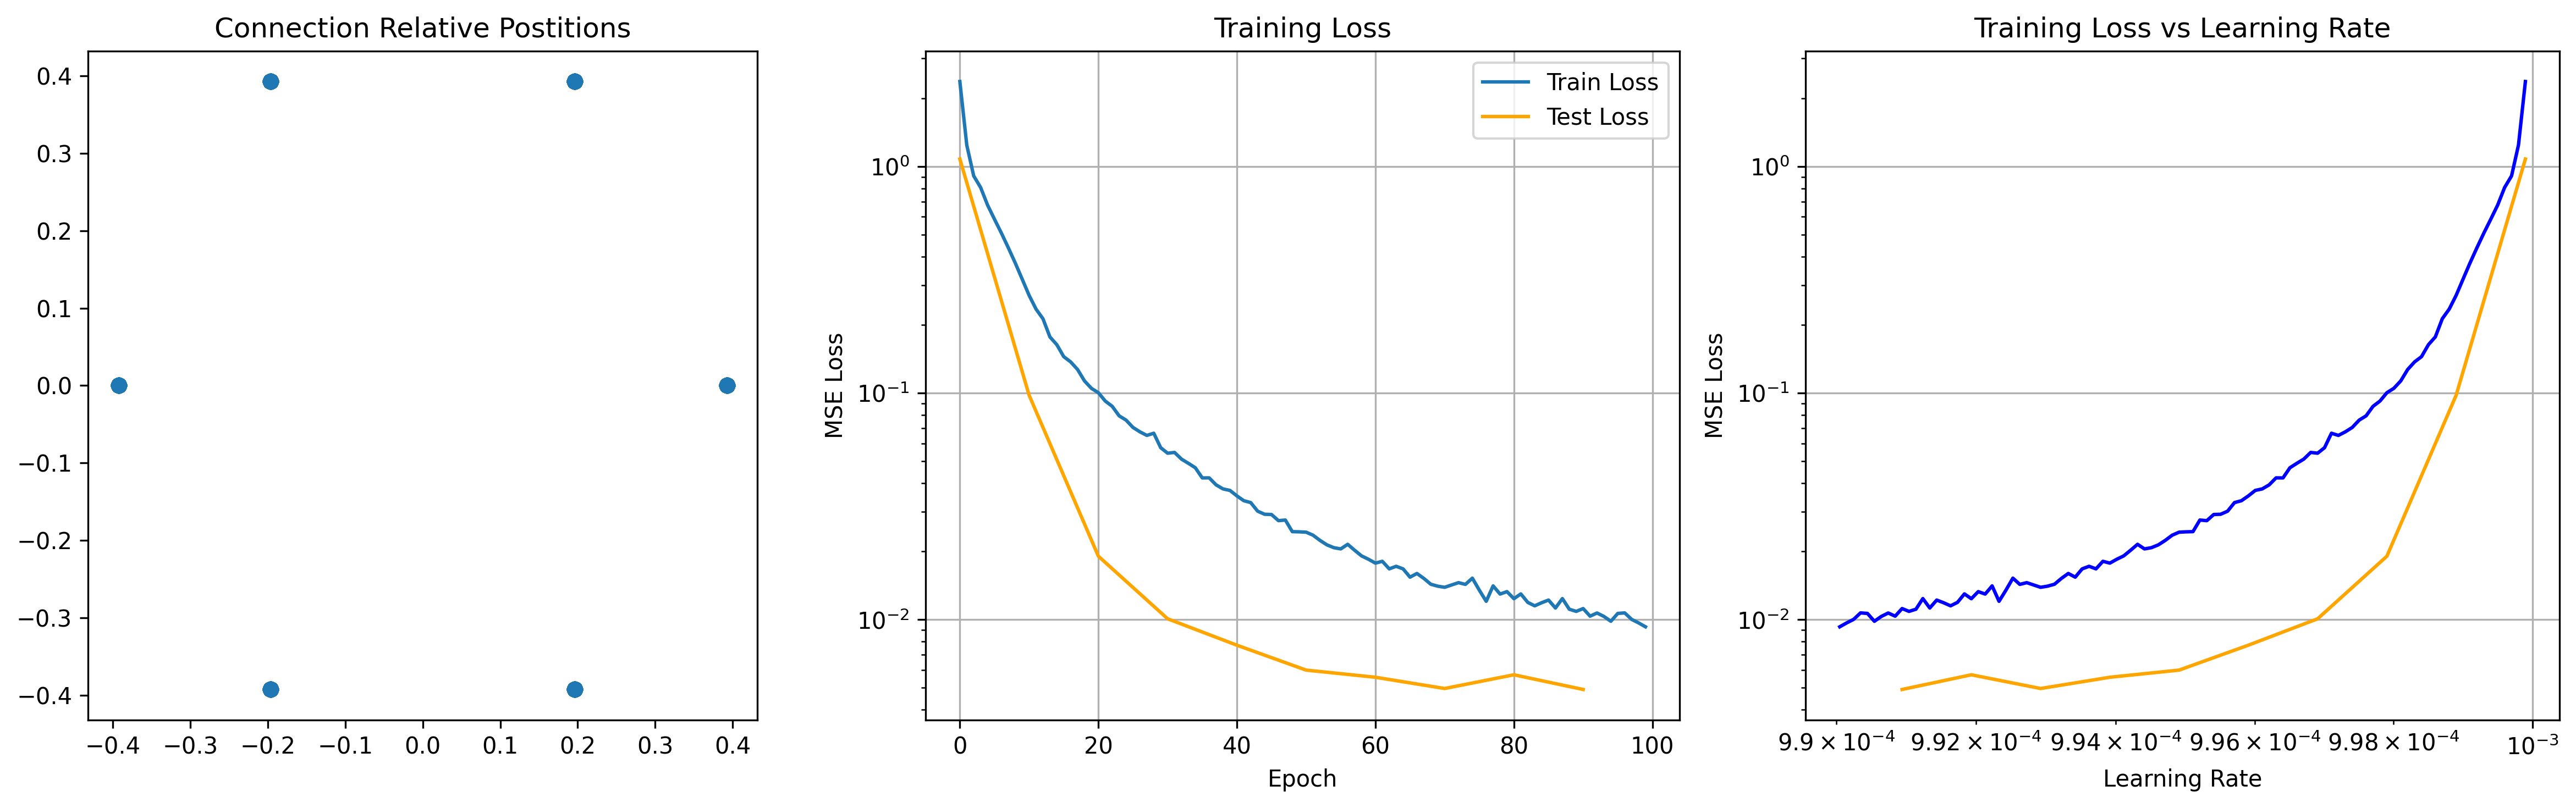

In [8]:

fig = plt.figure(figsize=(16,5),dpi=300)
ax = fig.add_subplot(131)
ax.scatter(edge_attr_combined[:,0],edge_attr_combined[:,1])
ax.set_aspect('equal')
ax.set_title('Connection Relative Postitions')

# fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(132)
ax.plot(loss_hist,label='Train Loss')
ax.plot(range(0,len(test_loss_hist)*test_interval,test_interval),test_loss_hist,label='Test Loss',c='orange')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Loss')
ax.grid(True)

ax = fig.add_subplot(133)
ax.plot(lr_hist,loss_hist, label='Train Loss', c='blue')
ax.plot(lr_hist[::test_interval],test_loss_hist,label='Test Loss', c='orange')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Loss vs Learning Rate')
ax.grid(True)

fig.tight_layout()
plt.show()

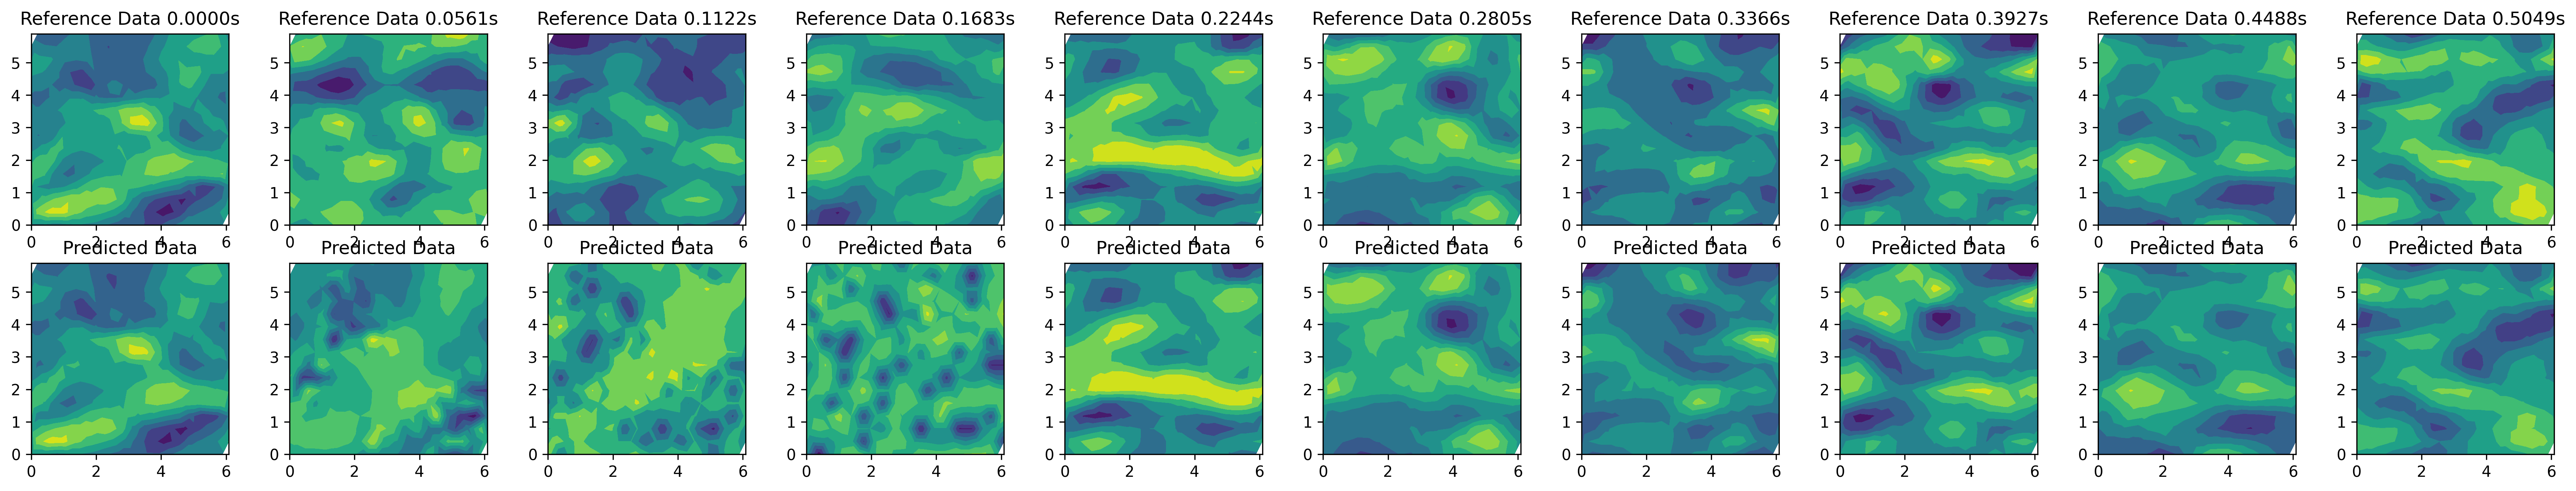

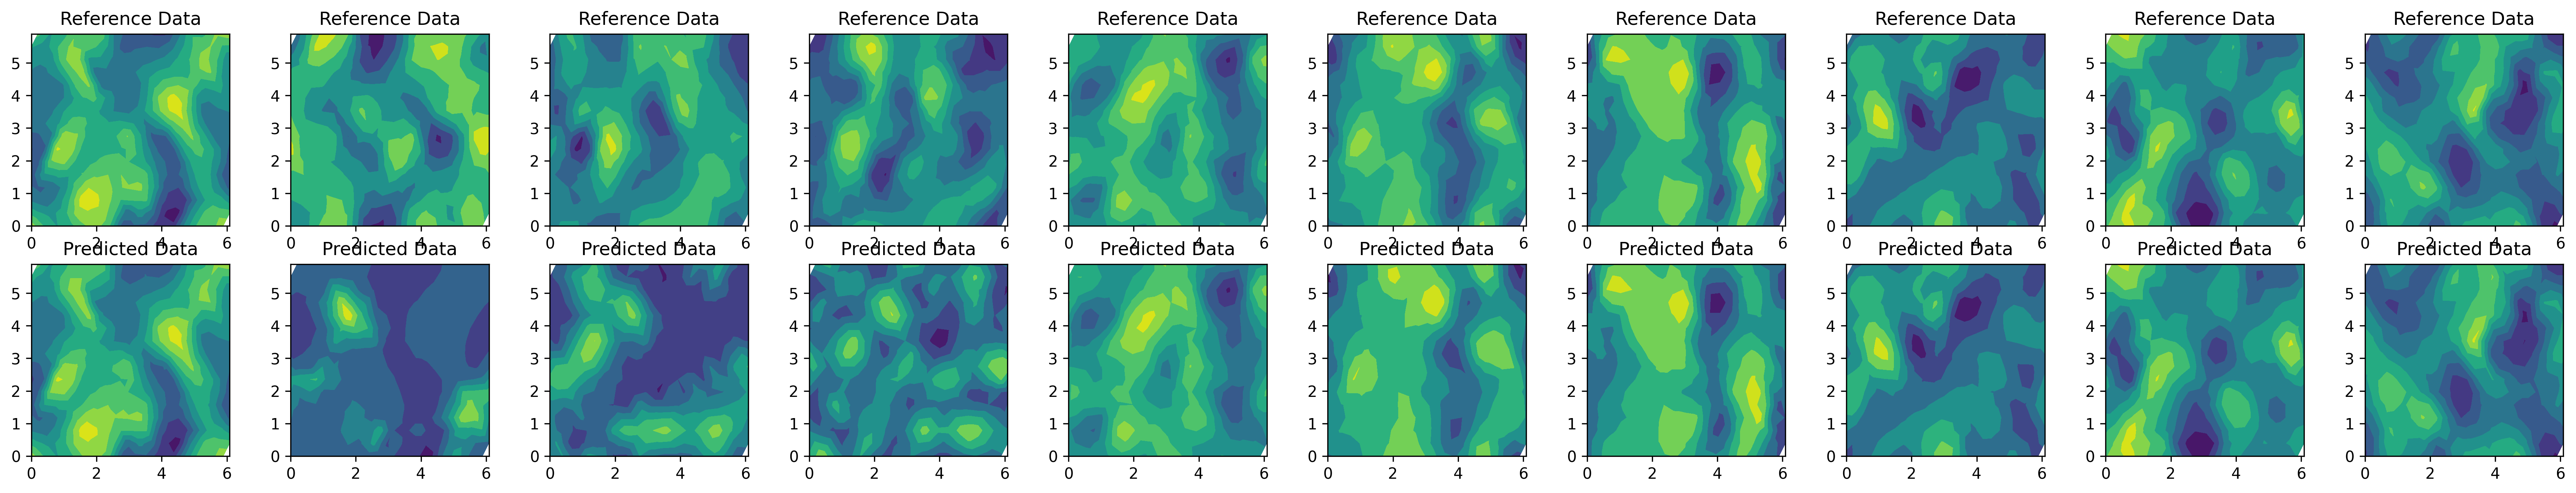

In [18]:
# test stability
inds = 0
test_unroll_data = torch.Tensor(test_data[inds,:-1]).to('mps')
test_unroll_target = torch.Tensor(test_data[inds,1:]).to('mps')

# print(test_unroll_data.shape)
# print(test_unroll_target.shape)

test_unroll_data = test_unroll_data.reshape(-1,rows*cols,2)
test_unroll_target = test_unroll_target.reshape(-1,rows*cols,2)

velocity = test_unroll_data[0].unsqueeze(0)
model_unroll = torch.empty_like(test_unroll_data).to('mps')
tmp_unroll = torch.empty_like(test_unroll_data).to('mps')

# print(test_input.shape)
# print(velocity.shape)
# print(tmp.shape)
tmp_unroll[0] = test_unroll_data[0] + tmp[inds,0]*dt_skip

model.eval()
for i in range(test_unroll_data.shape[1]):
    velocity = model(velocity,ij,e)

    # dudt = model(velocity,ij,e)
    # velocity = dudt*dt_skip + velocity
    model_unroll[i] = velocity[0].detach()

    if i > 0:
        tmp_unroll[i] = tmp_unroll[i-1] + tmp[inds,i]*dt_skip 


# tmp_unroll = torch.cumsum(tmp[0],dim=0)*dt_skip + test_unroll_data[0]
wtf = torch.cumsum(tmp[0],dim=0)*dt_skip + test_unroll_data[0]

# compare
model_unroll = model_unroll.cpu().numpy()
model_unroll = np.nan_to_num(model_unroll)
tmp_unroll = tmp_unroll.cpu().numpy()
test_unroll_target = test_unroll_target.cpu().numpy()
nplots = 10
time_inds = (np.linspace(0,test_data.shape[1]-2,nplots).astype(int))

# print(staggered_points_full_set_vel.shape)
# print(test_unroll_target.shape)
# print(model_unroll.shape)
# print(tmp_unroll)
# print(tmp.shape)


fig = plt.figure(figsize=(3*nplots,5),dpi=300)
for i,time_ind in enumerate(time_inds):
    # i = int(i)
    ax = fig.add_subplot(2,nplots,i+1)
    ax.tricontourf(staggered_points[:,0],staggered_points[:,1],test_unroll_target[time_ind,:,0])
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],test_data[inds,i,:,0])
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],train_data[inds,i,:,0])
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],staggered_points_full_set_vel[inds,i*10,:,:,0].flatten())

    ax.set_aspect('equal')
    ax.set_title('Reference Data %2.4fs'%(i*dt_skip))

    ax = fig.add_subplot(2,nplots,i+nplots+1)
    ax.tricontourf(staggered_points[:,0],staggered_points[:,1],model_unroll[time_ind,:,0])
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],tmp_unroll[time_ind,:,0])
    ax.set_aspect('equal')
    ax.set_title('Predicted Data')

fig = plt.figure(figsize=(3*nplots,5),dpi=300)
for i,time_ind in enumerate(time_inds):
    # i = int(i)
    ax = fig.add_subplot(2,nplots,i+1)
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],test_unroll_target[time_ind,:,1])
    ax.tricontourf(staggered_points[:,0],staggered_points[:,1],test_unroll_target[time_ind,:,1])
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],test_data[inds,i,:,0])
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],train_data[inds,i,:,0])
    # ax.tricontourf(staggered_points[:,0],staggered_points[:,1],staggered_points_full_set_vel[inds,i*10,:,:,0].flatten())

    ax.set_aspect('equal')
    ax.set_title('Reference Data')

    ax = fig.add_subplot(2,nplots,i+nplots+1)
    ax.tricontourf(staggered_points[:,0],staggered_points[:,1],model_unroll[time_ind,:,1])
    ax.set_aspect('equal')
    ax.set_title('Predicted Data')

plt.show()
# print(test_data[inds,i,:,0])




### Not sure what density is

### Calculate from navier stokes equations (incompressible) with non dimensionalized length and time scales with reynolds number 

$\frac{\partial u_i}{\partial t} = - \frac{d p}{\rho d x_i} - u_j \frac{\partial u_i}{\partial x_j} + \frac{1}{Re} \frac{\partial^2 u_j}{\partial x_i \partial x_j}$


$\frac{du_i}{dx_i} = 0$

### Filtered Navier stokes

In [35]:
# c
re = 1000
dt = data.stable_time_step

dudx1 = data.u.differentiate('x')
dvdy1 = data.v.differentiate('y')

res = dudx1+dvdy1
print('wtf continutity diff')
print(np.sqrt(res[:,-1]**2).mean().values)

print(data.u[:,0].mean().to_numpy())


u = data.u.to_numpy()
v = data.v.to_numpy()
p = data.pressure.to_numpy()

# u = u[:3,:3,:9,:9]
# v = v[:3,:3,:9,:9]
# p = p[:3,:3,:9,:9]


dx = data.x[1] - data.x[0]
dy = data.y[1] - data.y[0]

dx = dx.values
dy = dy.values

# centered difference derivitive calc
dudx = (np.roll(u,-1,axis=-2) - np.roll(u,1,axis=-2))/dx/2
dudy = (np.roll(u,-1,axis=-1) - np.roll(u,1,axis=-1))/dy/2

dvdx = (np.roll(v,-1,axis=-2) - np.roll(v,1,axis=-2))/dx/2
dvdy = (np.roll(v,-1,axis=-1) - np.roll(v,1,axis=-1))/dy/2

continuitiy_residual = dudx+dvdy

# continuitiy_residual1 = 0.5*(np.roll(u,-1,axis=-2))

print(np.sqrt(continuitiy_residual[:,-1]**2).mean())
print(continuitiy_residual[0,0,3:-3,3:-3])

# d2udxdy = np.gradient(dudx,axis=-1)/dy
# check = np.gradient(dvdy,axis=-2)/dx

# d2udxdy = (np.roll(dudx,-1,axis=-1)-np.roll(dudx,1,axis=-1))/dy/2
d2udxdx = (np.roll(u,-1,axis=-2) - 2*u + np.roll(u,1,axis=-2))/dx**2
d2udxdy = (np.roll(u,[-1,-1],axis=[-1,-2]) - np.roll(u,[-1,1],axis=[-1,-2]) - np.roll(u,[1,-1],axis=[-1,-2]) + np.roll(u,[1,1],axis=[-1,-2]))/dx/dy/4

d2vdydy = (np.roll(v,-1,axis=-1) - 2*v + np.roll(v,1,axis=-1))/dy**2
d2vdxdy = (np.roll(v,[-1,-1],axis=[-1,-2]) - np.roll(v,[-1,1],axis=[-1,-2]) - np.roll(v,[1,-1],axis=[-1,-2]) + np.roll(v,[1,1],axis=[-1,-2]))/dx/dy/4


advection_1 = u * dudx + v * dudy 
advection_2 = u * dvdx + v * dvdy 

visc_1 = (d2udxdx+d2vdxdy)/re
visc_2 = (d2udxdy+d2vdydy)/re

dudt = (np.roll(u,-1,axis=1) - np.roll(u,1,axis=1))/dt/2
dvdt = (np.roll(v,-1,axis=1) - np.roll(v,1,axis=1))/dt/2

dpdx_invrho = -(dudt+advection_1-visc_1)
dpdy_invrho = -(dvdt+advection_2-visc_2)

# print(dpdx_invrho[0,1])

bern_dpdx = (np.roll(p,-1,axis=-2) - np.roll(p,1,axis=-2))/dx/2
bern_dpdy = (np.roll(p,-1,axis=-1) - np.roll(p,1,axis=-1))/dy/2
# print(bern_dpdx[0,1])

print((dpdx_invrho[0,1]/bern_dpdx[0,1])[3:-3,3:-3])
print((dpdy_invrho[0,1]/bern_dpdy[0,1])[3:-3,3:-3])

# print(d2udxdy - d2vdxdy)
# print(d2vdxdy - check2)

# momentum_residual = 


wtf continutity diff
0.5050497
-6.693881e-08


AttributeError: 'Dataset' object has no attribute 'pressure'

In [ ]:
pass
with open('config.txt','w') as f:
    f.write(data.attrs['full_config_str'])

with open('physics_config.txt','w') as f:
    f.write(data.attrs['physics_config_str'])

print(data.attrs['warmup_time'])
print(data.attrs['simulation_time'])
print(data.attrs['simulation_time'])
print(data.stable_time_step)

print(data.attrs)